# Clustering

In [1]:
#general packages
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in data
data = pd.read_csv("/groups/CaiLab/personal/Lex/raw/250113_mb_BSpeg_xtra_potentialTriton/pyfish_tools/output/genebycell/final_1.01.41.4_seed33_heg_svm_p20.0_diff0_fdr5.0/genebycell_1.csv", index_col=0)
#remove rows that doesn't correspond to a gene
data = data[~data.index.str.contains("fake")]

In [3]:
# Convert to AnnData object
adata = sc.AnnData(data.T)
#make sure cells are obs and genes are vars
adata

AnnData object with n_obs × n_vars = 1984 × 160

In [4]:
# Filter genes that are expressed in fewer than 1 cells
sc.pp.filter_genes(adata, min_cells=1)
# Filter cells that have fewer than n genes expressed
sc.pp.filter_cells(adata, min_genes=0)
# CPM normalization
sc.pp.normalize_total(adata, target_sum=1e6)
# Log-transform the data
sc.pp.log1p(adata)  
# Use N number of top genes (all since they are all marker genes)
sc.pp.highly_variable_genes(adata, n_top_genes=adata.n_vars, subset=True)
# Z-score normalize and clip any value beyond 10 sigmas
sc.pp.scale(adata, max_value=10)
# Perform PCA to reduce dimensions and keep using arpack for consistent solutions
sc.tl.pca(adata, svd_solver='arpack', n_comps=adata.n_vars-1)

In [5]:
# Get the explained variance ratio
explained_variance_ratio = adata.uns['pca']['variance_ratio']
# Calculate the cumulative sum of explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
# Find the number of components that account for 90% of the variance
num_pcs_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1  # Add 1 because indices start at 0
print(f"Number of principal components that account for 90% of the variance: {num_pcs_90}")

Number of principal components that account for 90% of the variance: 122


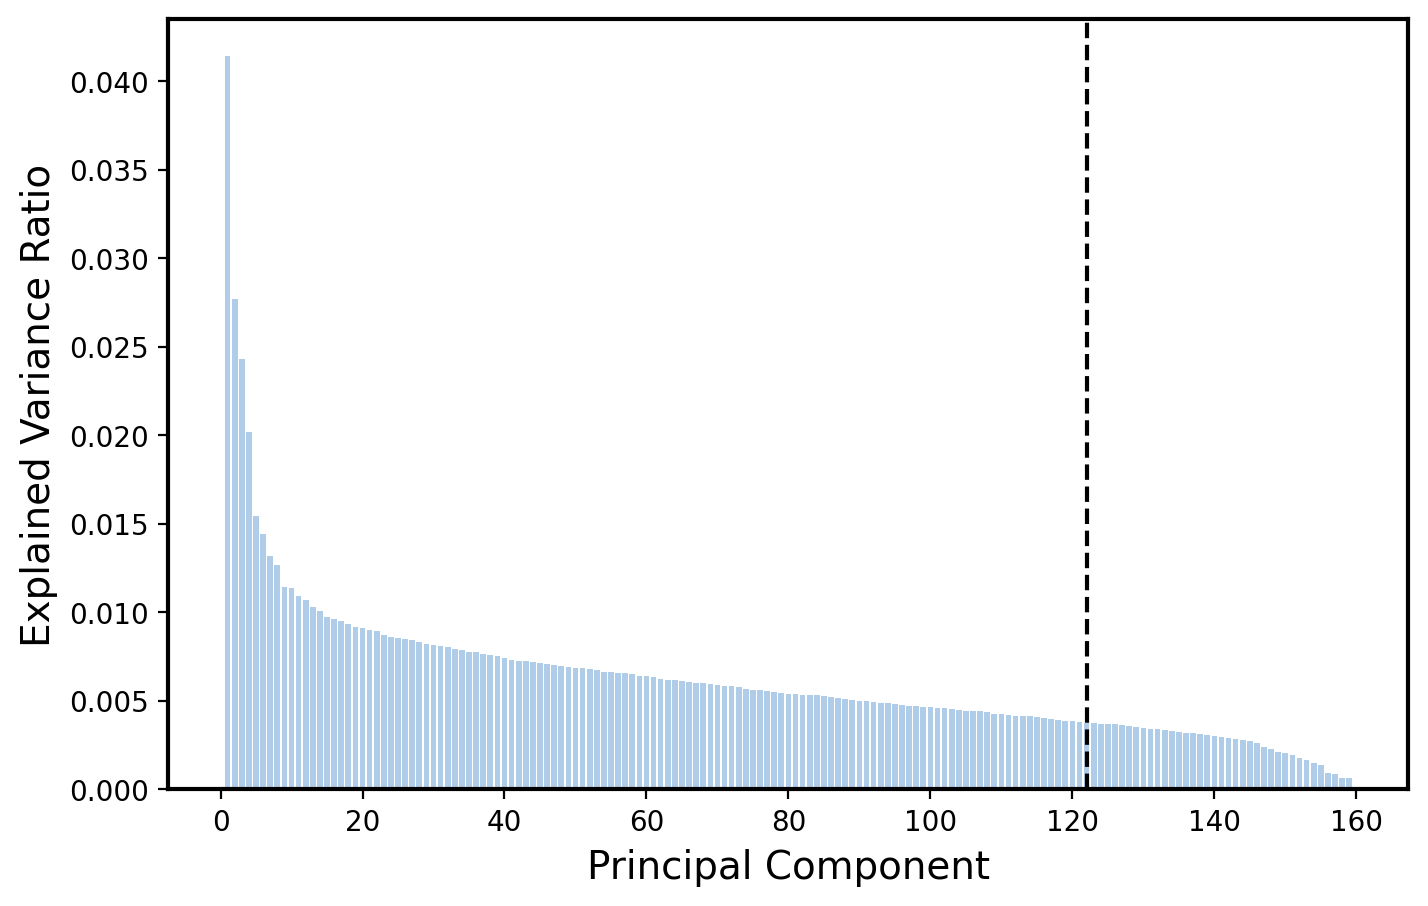

In [6]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.9, color='#A7C7E7', lw=2)
plt.xlabel('Principal Component', size = 14)
plt.ylabel('Explained Variance Ratio', size = 14)
plt.title('')
# Customize the plot (adding black box edges)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
# You can also set the thickness of the edges (optional)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.axvline(num_pcs_90, ls = "--", color = "k")
# Save the plot as an SVG file
#plt.savefig('Variance_Ratio_Plot.svg', format='svg')
plt.show()

In [7]:
# Generate neighborhood graph. Use only top PCs that gives >90% of variance
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=num_pcs_90)
# Perform UMAP on neighborhood graph
sc.tl.umap(adata, min_dist=0.1, spread=3, random_state=42)
# Perform community based clustering using leiden on neighborhood graph
sc.tl.leiden(adata, resolution=1) 

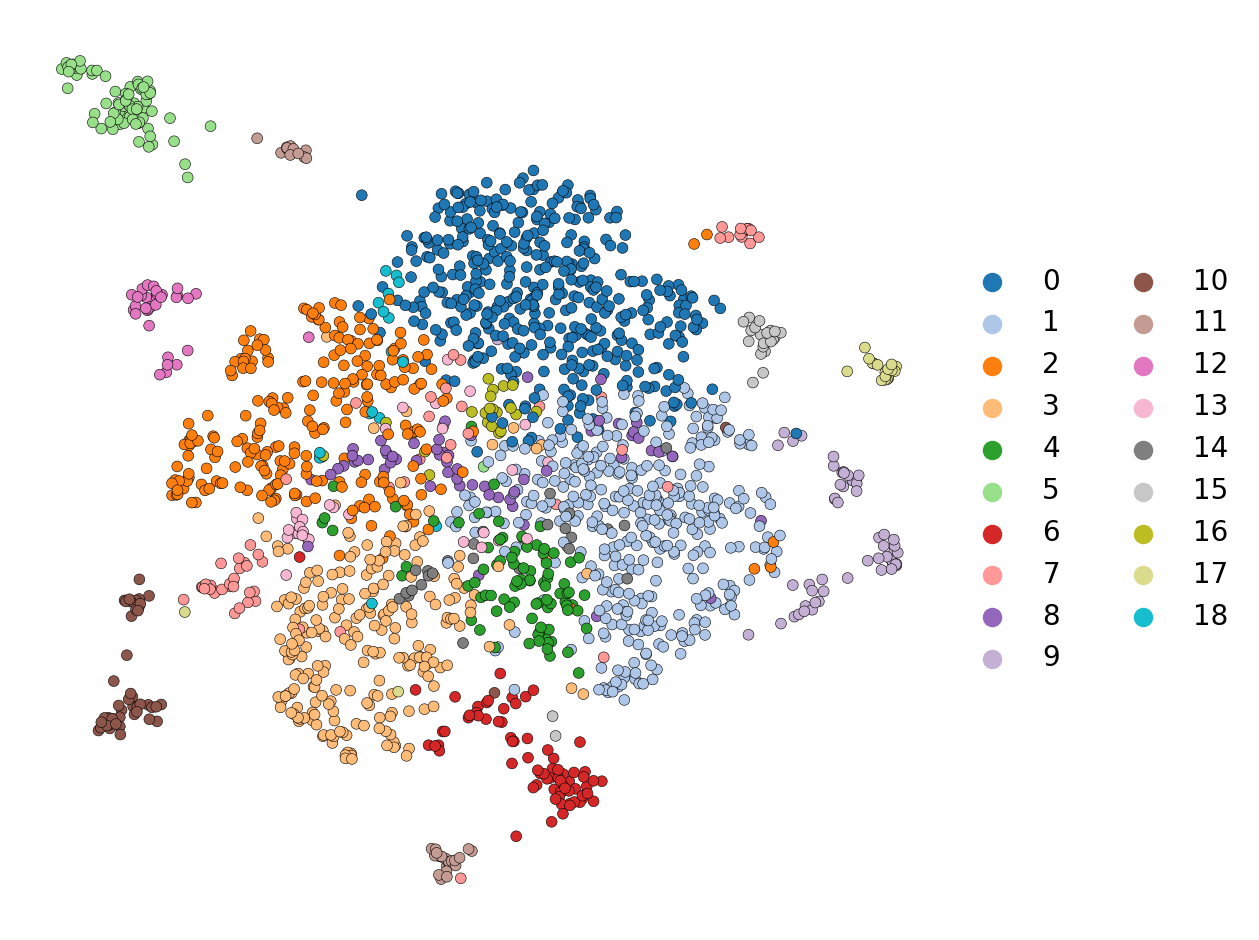

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Automatically adjust palette size based on clusters
num_clusters = adata.obs['leiden'].nunique()
custom_palette = sns.color_palette("tab20", num_clusters)

# Plot UMAP with updated palette
sc.pl.umap(
    adata, 
    color=["leiden"], 
    palette=custom_palette,
    title="",
    edgecolor='black',  
    linewidth=0.2,  # Add edge around the dots
    frameon=False,  
    show=False  
)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

for handle in handles:
    handle.set_edgecolor('black')
    handle.set_linewidth(0.5)

plt.tight_layout()  # Prevents overlapping of plot and legend
plt.show()


# Cell typing

In [9]:
#load annotations data
annotations = pd.read_csv("/groups/CaiLab/personal/Lex/raw/250113_mb_BSpeg_xtra_potentialTriton/mouse_brain_extra/Xenium_mBrain_v1.1_metadata.csv")

In [10]:
# Perform differential expression across clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') 

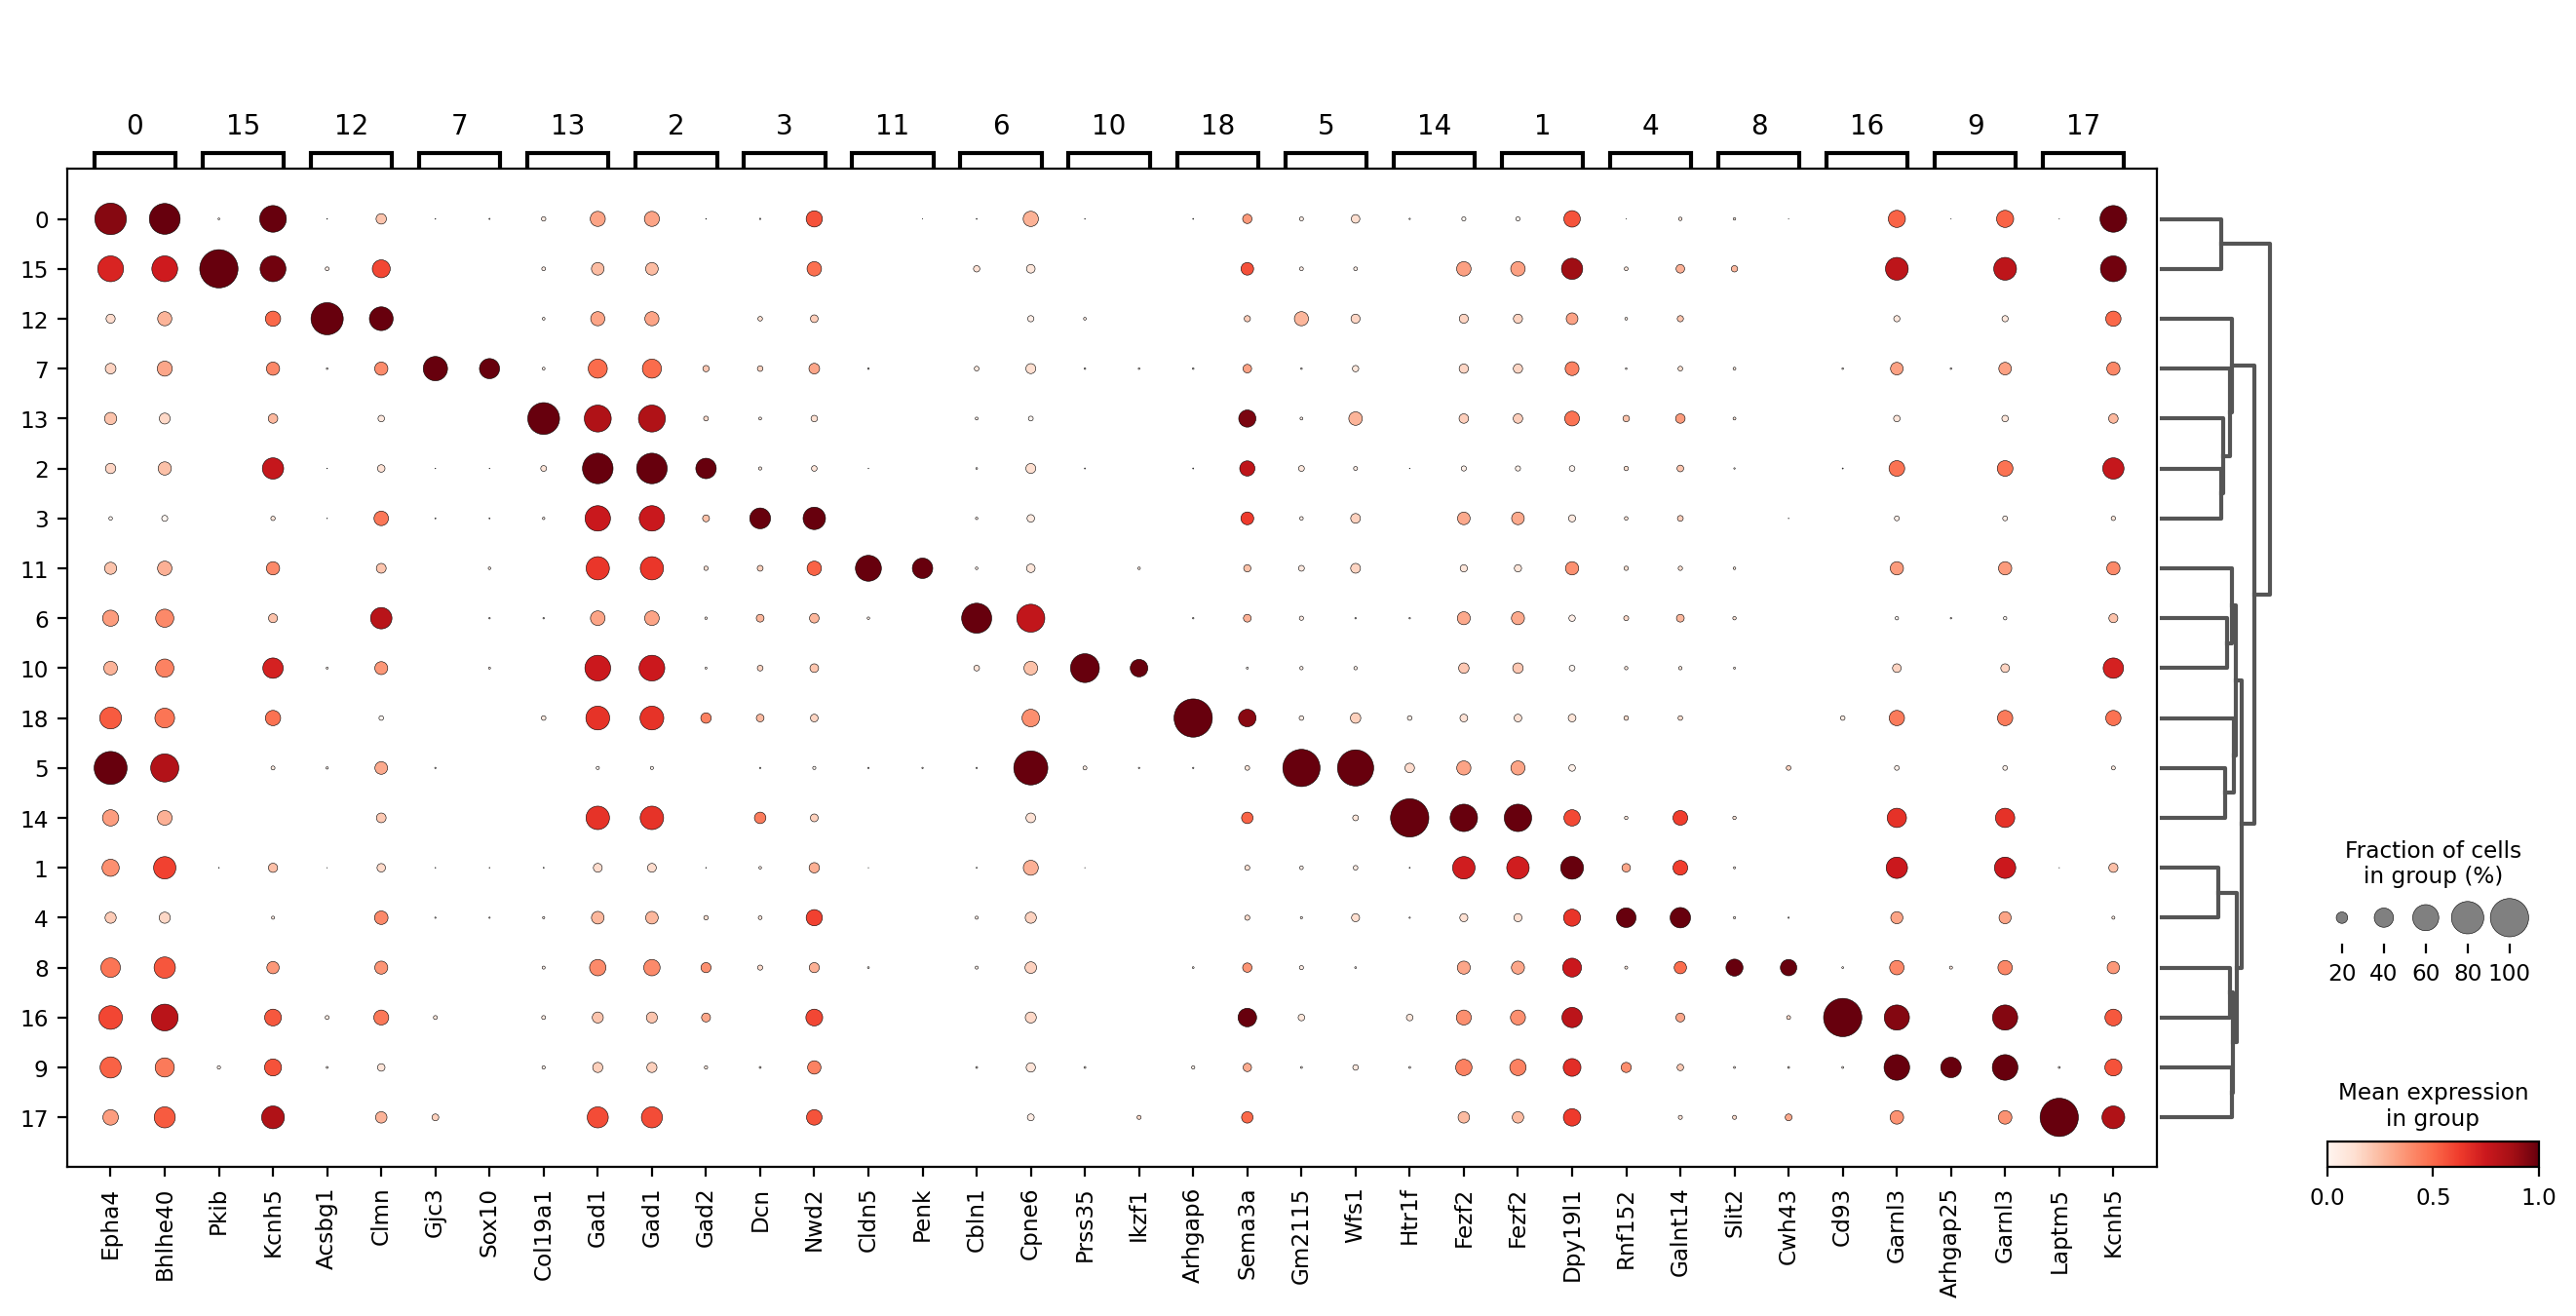

In [11]:
#look at dot plot for top 2 genes per cluster
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=2
)

In [12]:
# Extract the results into a DataFrame
marker_genes = sc.get.rank_genes_groups_df(adata, group=None)

In [13]:
# Get unique marker genes
unique_marker_genes = marker_genes['names'].unique()

# Filter your annotation DataFrame for these marker genes
annotated_markers = annotations[annotations['Genes'].isin(unique_marker_genes)]

In [14]:
# Get list of clusters
clusters = adata.obs['leiden'].unique()

# Initialize dictionary
cluster_markers = {}

for cluster in clusters:
    # Extract marker genes for the cluster
    markers_df = marker_genes[marker_genes['group'] == cluster]
    # Select top N marker genes (e.g., top 5)
    top_markers = markers_df.head(5)['names'].tolist()
    cluster_markers[cluster] = top_markers

# Example output
for cluster, genes in cluster_markers.items():
    print(f"Cluster {cluster}: {genes}")

Cluster 5: ['Gm2115', 'Wfs1', 'Sipa1l3', 'Cpne6', 'Fibcd1']
Cluster 2: ['Gad1', 'Gad2', 'Kcnh5', 'Adamts2', 'Sema3a']
Cluster 3: ['Dcn', 'Nwd2', 'Kcnmb2', 'Gad1', 'Arhgap12']
Cluster 13: ['Col19a1', 'Gad1', 'Eya4', 'Sema3a', 'Tmem132d']
Cluster 4: ['Rnf152', 'Galnt14', 'Igfbp6', 'Nrep', 'Cdh9']
Cluster 12: ['Acsbg1', 'Clmn', 'Gfap', 'Gng12', 'Adamts2']
Cluster 1: ['Fezf2', 'Dpy19l1', 'Garnl3', 'Nrep', 'Galnt14']
Cluster 6: ['Cbln1', 'Cpne6', 'Igfbp5', 'Nrep', 'Opn3']
Cluster 18: ['Arhgap6', 'Sema3a', 'Slc17a7', 'Gsg1l', 'Adamts2']
Cluster 11: ['Cldn5', 'Penk', 'Rims3', 'Gad1', 'Thsd7a']
Cluster 7: ['Gjc3', 'Sox10', 'Adamtsl1', 'Gpr17', 'Sema6a']
Cluster 8: ['Slit2', 'Cwh43', 'Plch1', 'Neto2', 'Cd68']
Cluster 14: ['Htr1f', 'Fezf2', 'Tmem132d', 'Trpc4', 'Vwc2l']
Cluster 17: ['Laptm5', 'Kcnh5', 'Kctd12', 'Tmem132d', 'Prr16']
Cluster 16: ['Cd93', 'Garnl3', 'Slc17a7', 'Bhlhe40', 'Sema3a']
Cluster 9: ['Arhgap25', 'Garnl3', 'Rprm', 'Sema5b', 'Arc']
Cluster 0: ['Epha4', 'Bhlhe40', 'Cux2', 'Sat

In [15]:
# Create a dictionary mapping genes to cell types
gene_to_celltype = annotations.set_index('Genes')['Annotation'].to_dict()

# Inspect the mapping
print(list(gene_to_celltype.items())[:10])

[('2010300C02Rik', 'CA2'), ('Acsbg1', 'Astrocytes'), ('Acta2', 'Pericytes / smooth muscle cells'), ('Acvrl1', 'Endothelial cells'), ('Adamts2', 'L2 IT ENTm'), ('Adamtsl1', 'CT SUB'), ('Adgrl4', 'Endothelial cells'), ('Aldh1a2', 'VLMC'), ('Angpt1', 'L5 PPP'), ('Ano1', 'Pericytes / smooth muscle cells')]


In [16]:
# Get the list of unique cell types
cell_types = annotations['Annotation'].unique()

# Initialize a DataFrame with clusters as rows and cell types as columns
summary_df = pd.DataFrame(0, index=clusters, columns=cell_types)

In [17]:
for cluster, genes in cluster_markers.items():
    for gene in genes:
        # Check if the gene is in the mapping
        if gene in gene_to_celltype:
            cell_type = gene_to_celltype[gene]
            # If a gene maps to multiple cell types, split and iterate
            if isinstance(cell_type, str) and ',' in cell_type:
                cell_type_list = [ct.strip() for ct in cell_type.split(',')]
            elif isinstance(cell_type, list):
                cell_type_list = cell_type
            else:
                cell_type_list = [cell_type]
            
            for ct in cell_type_list:
                if ct in summary_df.columns:
                    summary_df.at[cluster, ct] += 1
                else:
                    # If cell type is not in the summary_df, you might want to add it
                    summary_df.loc[cluster, ct] = 1

In [18]:
# Initialize a dictionary to store cluster annotations
cluster_annotations = {}

for cluster in summary_df.index:
    # Get the cell type with the maximum count for the cluster
    top_cell_type = summary_df.loc[cluster].idxmax()
    max_count = summary_df.loc[cluster].max()
    
    # Optionally, set a threshold (e.g., at least 2 marker genes)
    if max_count >= 0:
        cluster_annotations[cluster] = top_cell_type
    else:
        cluster_annotations[cluster] = 'Unknown'

# Display the cluster annotations
for cluster, cell_type in cluster_annotations.items():
    print(f"Cluster {cluster}: {cell_type}")


Cluster 5: CA1-ProS
Cluster 2: Lamp5 interneurons
Cluster 3: L2 IT ENTm
Cluster 13: Car3
Cluster 4: L4 RSP-ACA
Cluster 12: Astrocytes
Cluster 1: L5 PPP
Cluster 6: L4 RSP-ACA
Cluster 18: L2 IT ENTm
Cluster 11: Vip interneurons
Cluster 7: Oligodendrocytes
Cluster 8: Microglia / perivascular macrophages
Cluster 14: Car3
Cluster 17: L4/5 IT CTX
Cluster 16: L2 IT ENTl
Cluster 9: L6 CT CTX
Cluster 0: L4/5 IT CTX
Cluster 10: Pericytes / smooth muscle cells
Cluster 15: L4/5 IT CTX


In [19]:
# Create a mapping Series
cluster_to_celltype = pd.Series(cluster_annotations, name='cell_type')

# Map the annotations to cells based on their cluster
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

# Verify the mapping
print(adata.obs[['leiden', 'cell_type']].head())

               leiden           cell_type
Cell5.0_Pos_1       5            CA1-ProS
Cell16.0_Pos_1      5            CA1-ProS
Cell18.0_Pos_1      2  Lamp5 interneurons
Cell30.0_Pos_1      2  Lamp5 interneurons
Cell32.0_Pos_1      3          L2 IT ENTm


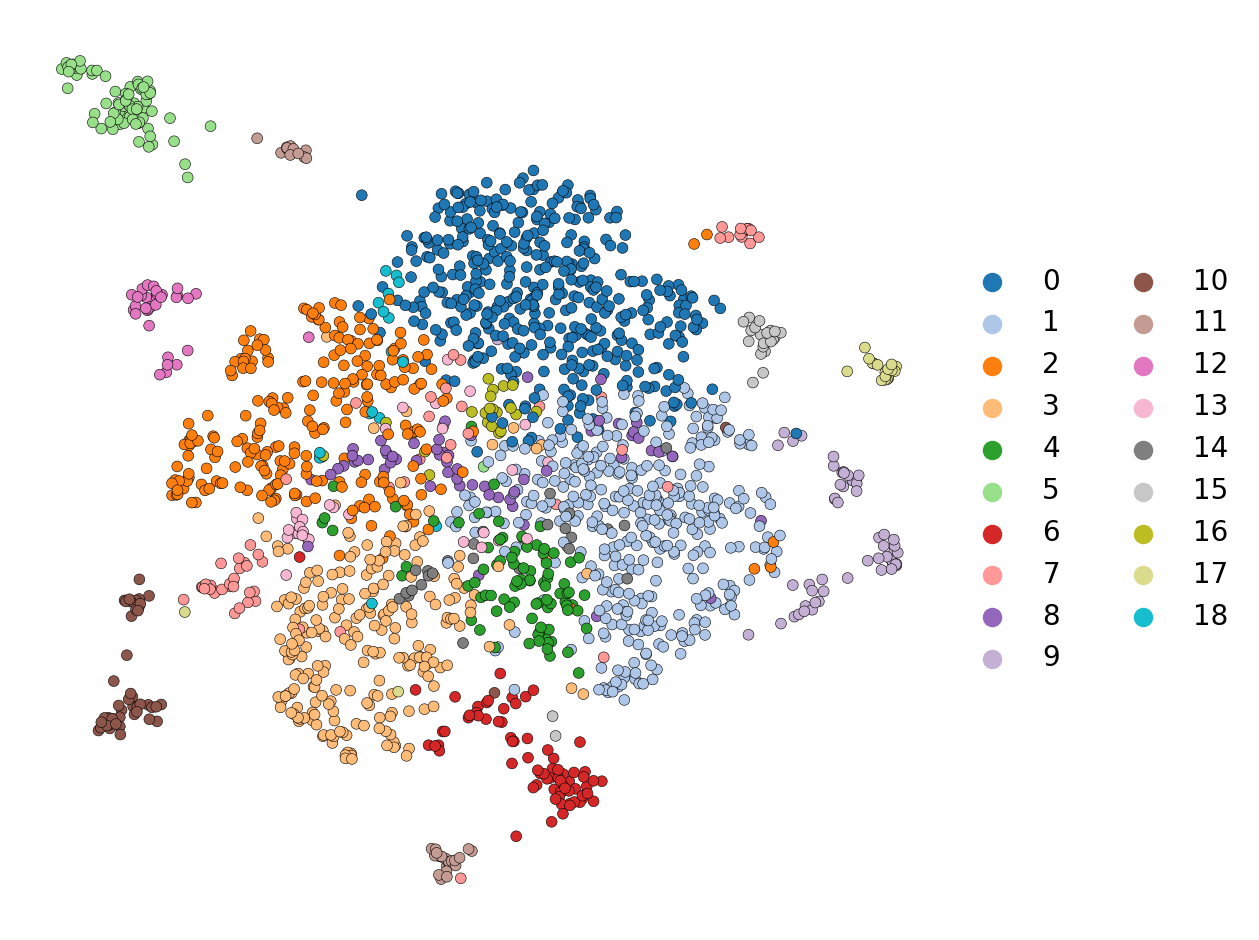

In [20]:
# Automatically adjust palette size based on clusters
num_clusters = adata.obs['leiden'].nunique()
custom_palette = sns.color_palette("tab20", num_clusters)

# Plot UMAP with updated palette
sc.pl.umap(
    adata, 
    color=["leiden"], 
    palette=custom_palette,
    title="",
    edgecolor='black',  
    linewidth=0.2,  # Add edge around the dots
    frameon=False,  
    show=False  
)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

for handle in handles:
    handle.set_edgecolor('black')
    handle.set_linewidth(0.5)

plt.tight_layout()  # Prevents overlapping of plot and legend
plt.show()


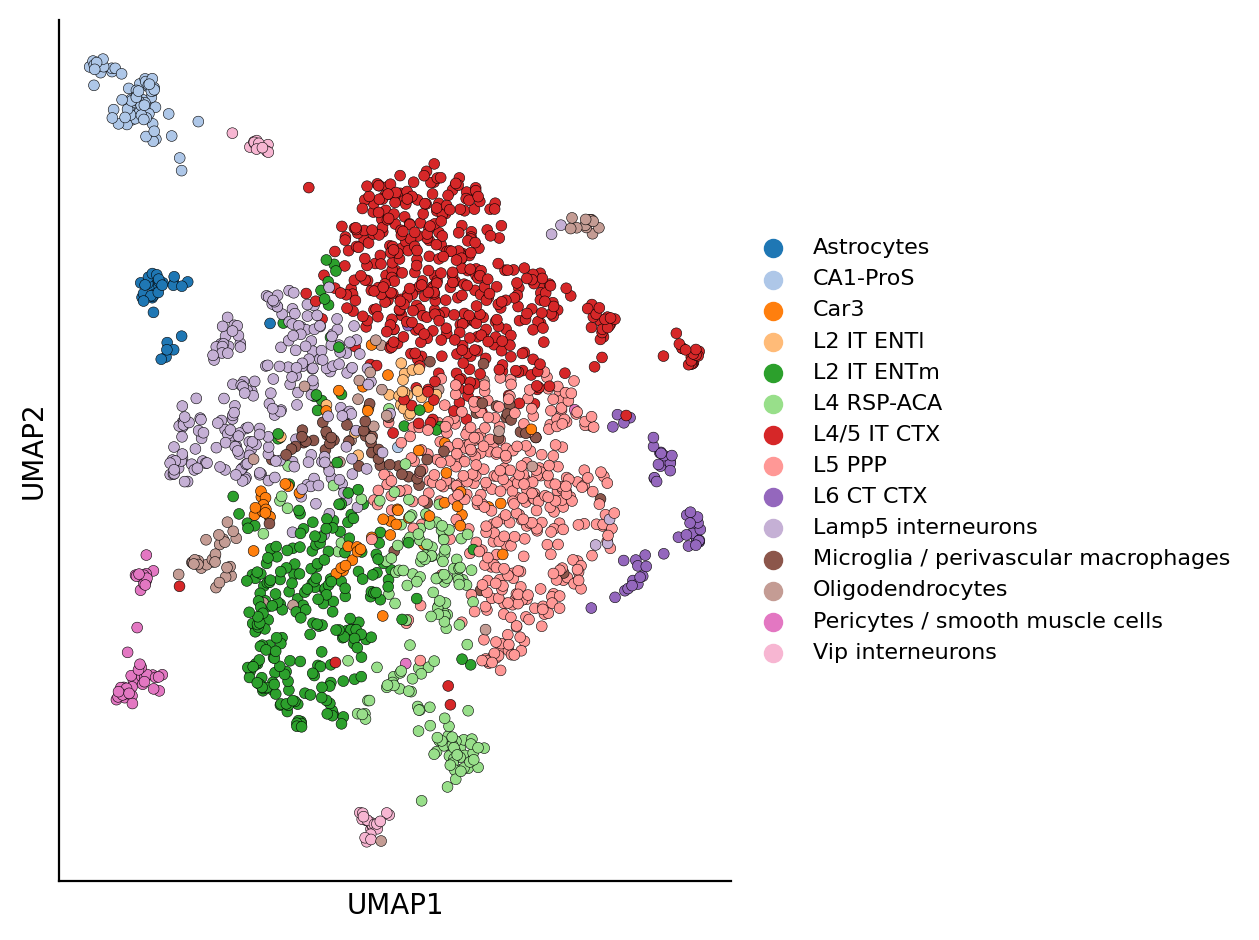

In [21]:
# Generate a custom palette with a size matching the unique cell types
num_cell_types = adata.obs['cell_type'].nunique()
custom_palette = sns.color_palette("tab20", num_cell_types)

# Create a dictionary to explicitly map each category to a color
category_colors = dict(zip(adata.obs['cell_type'].cat.categories, custom_palette))

# Plot UMAP
sc.pl.umap(
    adata,
    color='cell_type',
    palette=custom_palette,  # Pass the dictionary
    title='',       # Add title
    legend_fontsize=8,        # Smaller font size
    legend_fontoutline=0.5,   # Outline for readabilit
    edgecolor='black',  
    linewidth=0.2,  # Add edge around the dots
    show=False  
)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

for handle in handles:
    handle.set_edgecolor('black')
    handle.set_linewidth(0.5)

sns.despine()
plt.tight_layout()  # Prevents overlapping of plot and legend
# Save as SVG
output_svg_file = "umap_cell_types.svg"
plt.savefig(output_svg_file, format="svg", dpi=300)  # Specify format and resolution
plt.show()

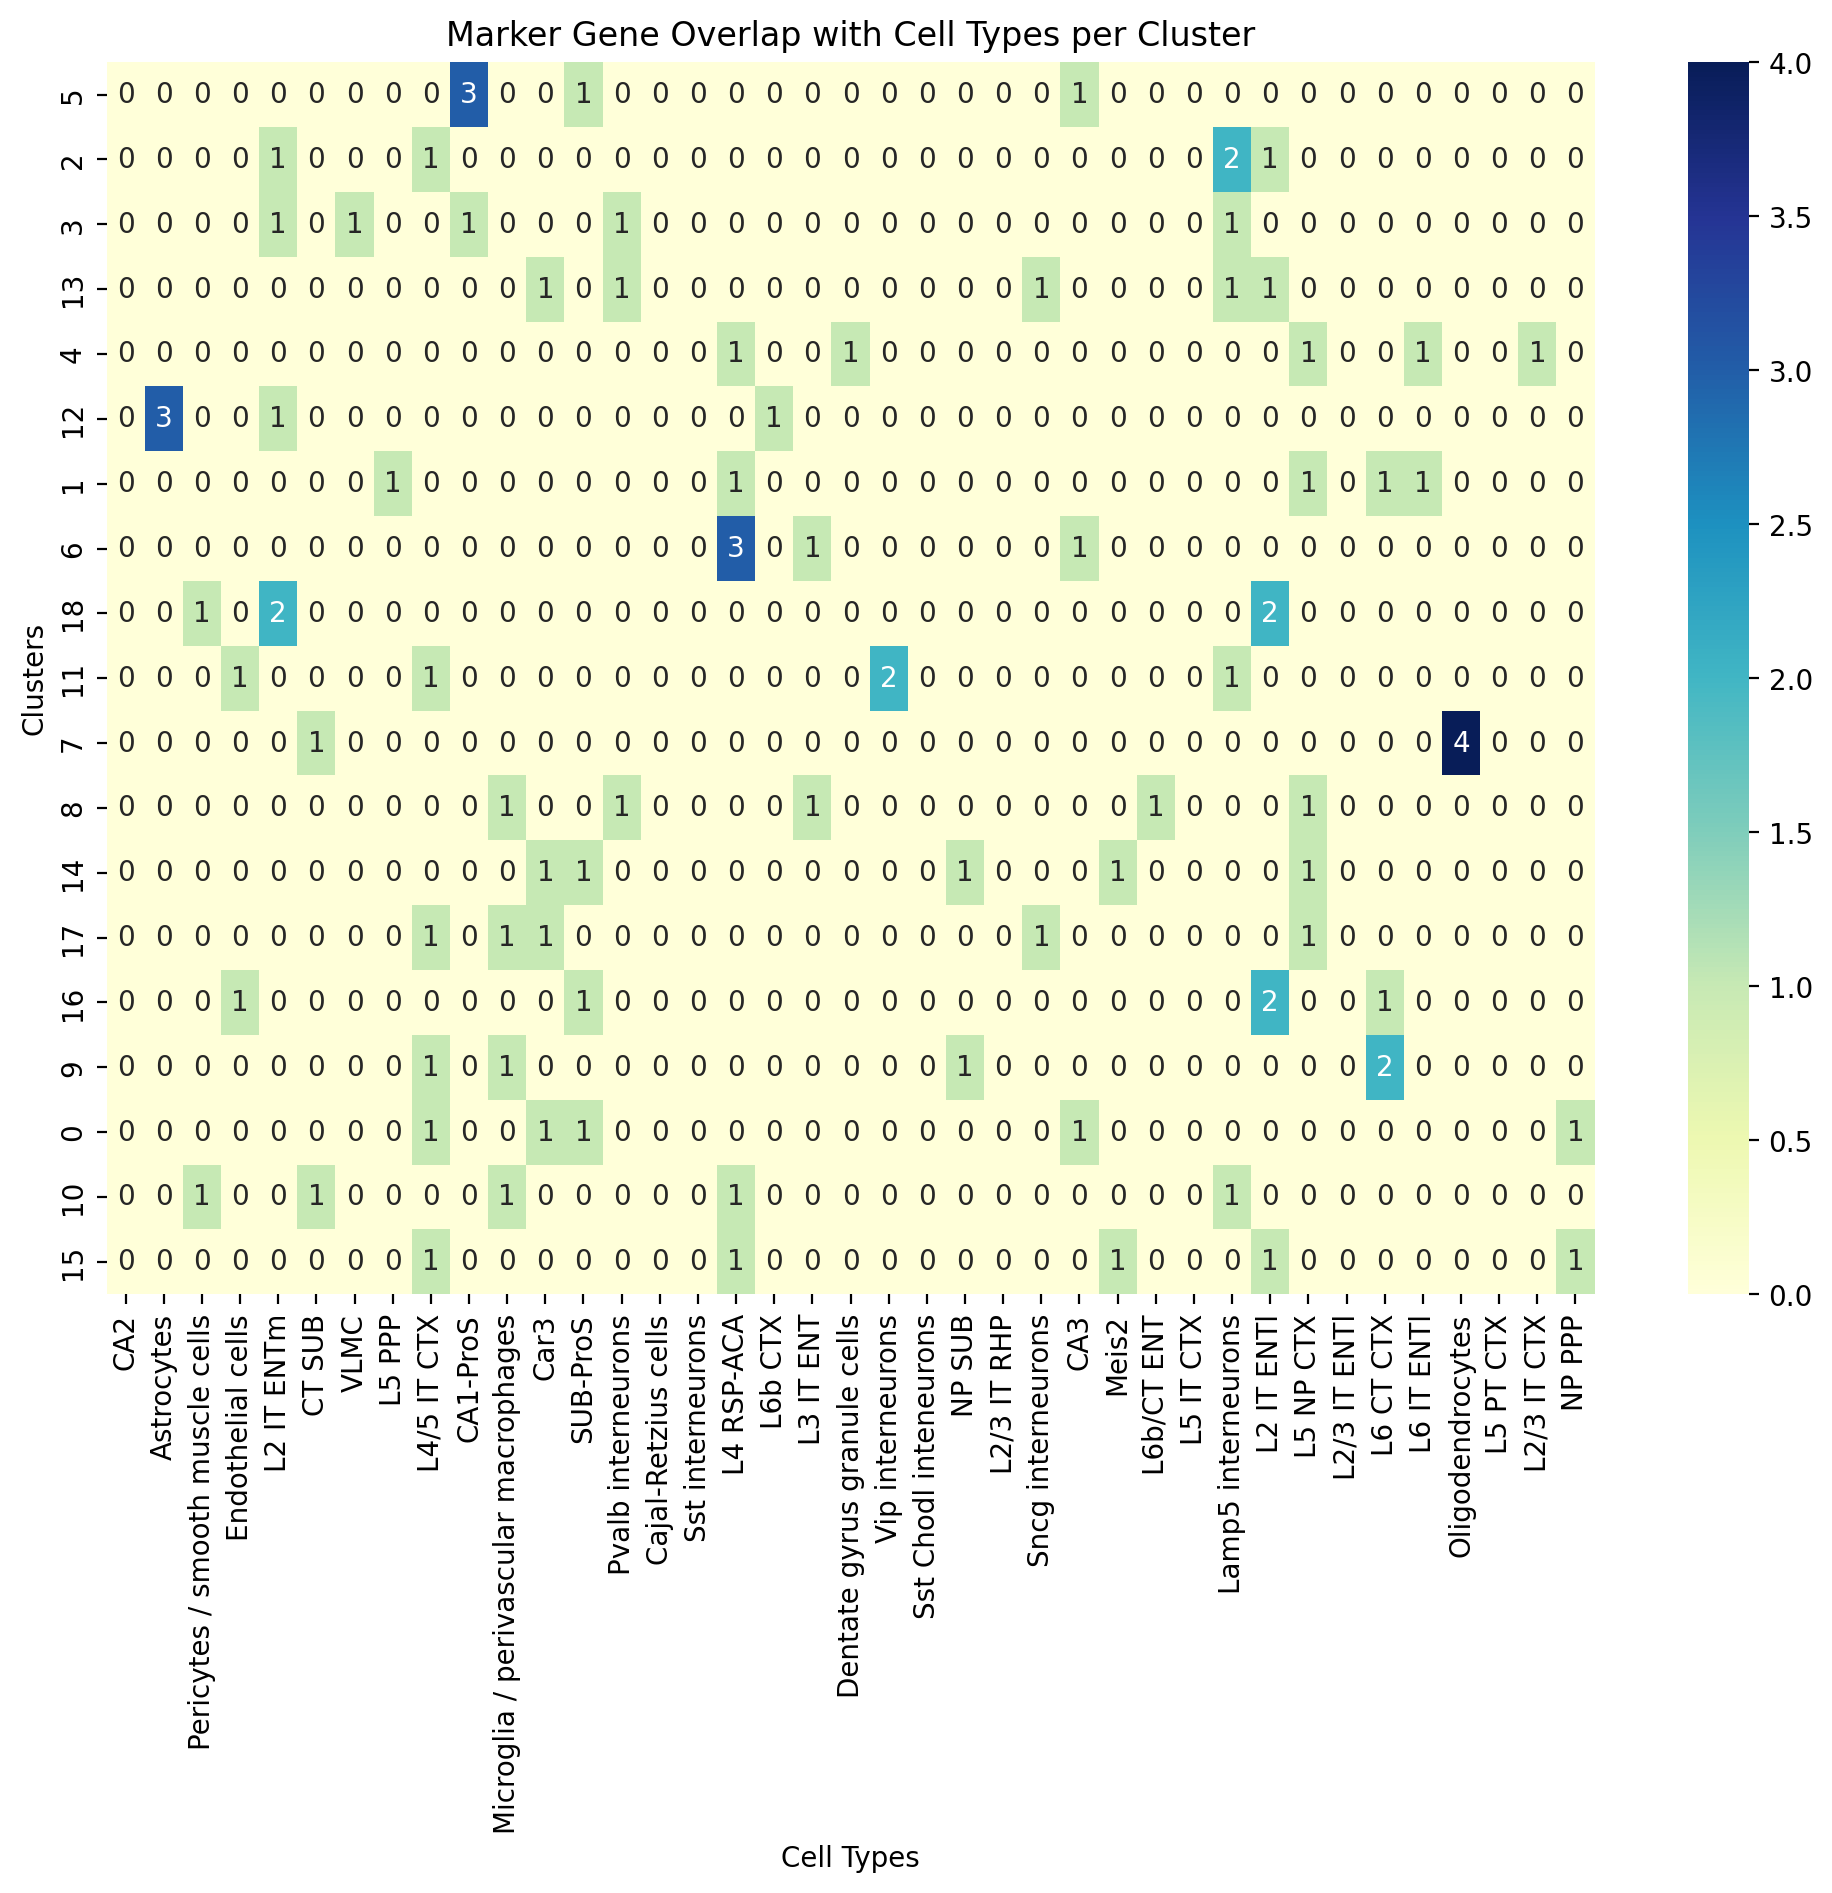

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(summary_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Marker Gene Overlap with Cell Types per Cluster')
plt.xlabel('Cell Types')
plt.ylabel('Clusters')
plt.show()


# Spatial Map

In [51]:
import tifffile as tf

#path
mask_path = "/groups/CaiLab/personal/Lex/raw/250113_mb_BSpeg_xtra_potentialTriton/pyfish_tools/output/edges_deleted/MMStack_Pos5_z0.tif"
#read mask
mask = tf.imread(mask_path)
# Extract Pos information from filename (assuming consistent naming)
pos = int(mask_path.split("Pos")[1].split("_")[0]) 

#make copy
mask_copy = mask.copy().astype(np.int16)
#grab leiden labels
labels = pd.DataFrame(adata.obs["cell_type"])

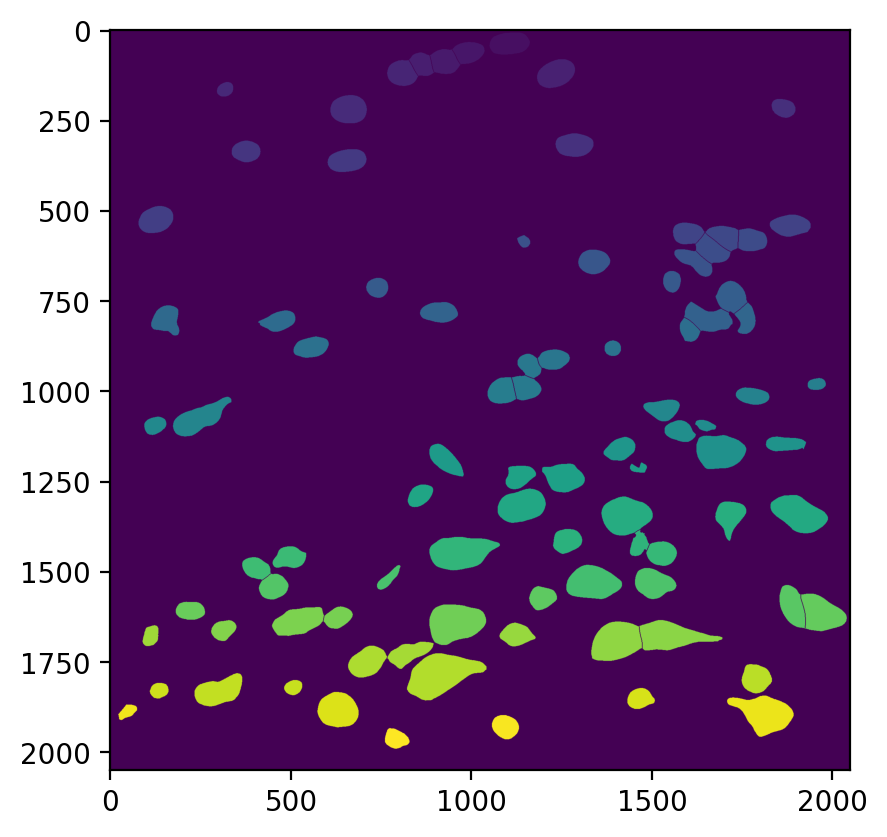

In [52]:
plt.imshow(mask)
plt.show()

In [53]:
# Parse cell_id and Pos from the index
labels.reset_index(inplace=True)
labels[['cell_id', 'pos']] = labels['index'].str.extract(r'Cell(\d+)\.0_Pos_(\d+)', expand=True).astype(int)
labels = labels[['cell_id', 'pos', 'cell_type']]

# Filter labels for the current Pos
labels = labels[labels['pos'] == pos]

#make cell type dictionary
celltype_def = dict(zip(labels['cell_id'], labels['cell_type']))

In [59]:
labels

,cell_id,pos,cell_type
19,60,5,Astrocytes
20,64,5,L5 PPP
21,74,5,L4 RSP-ACA
22,76,5,L5 PPP
23,80,5,L4 RSP-ACA
24,81,5,L5 PPP
25,86,5,Astrocytes
26,94,5,L4 RSP-ACA


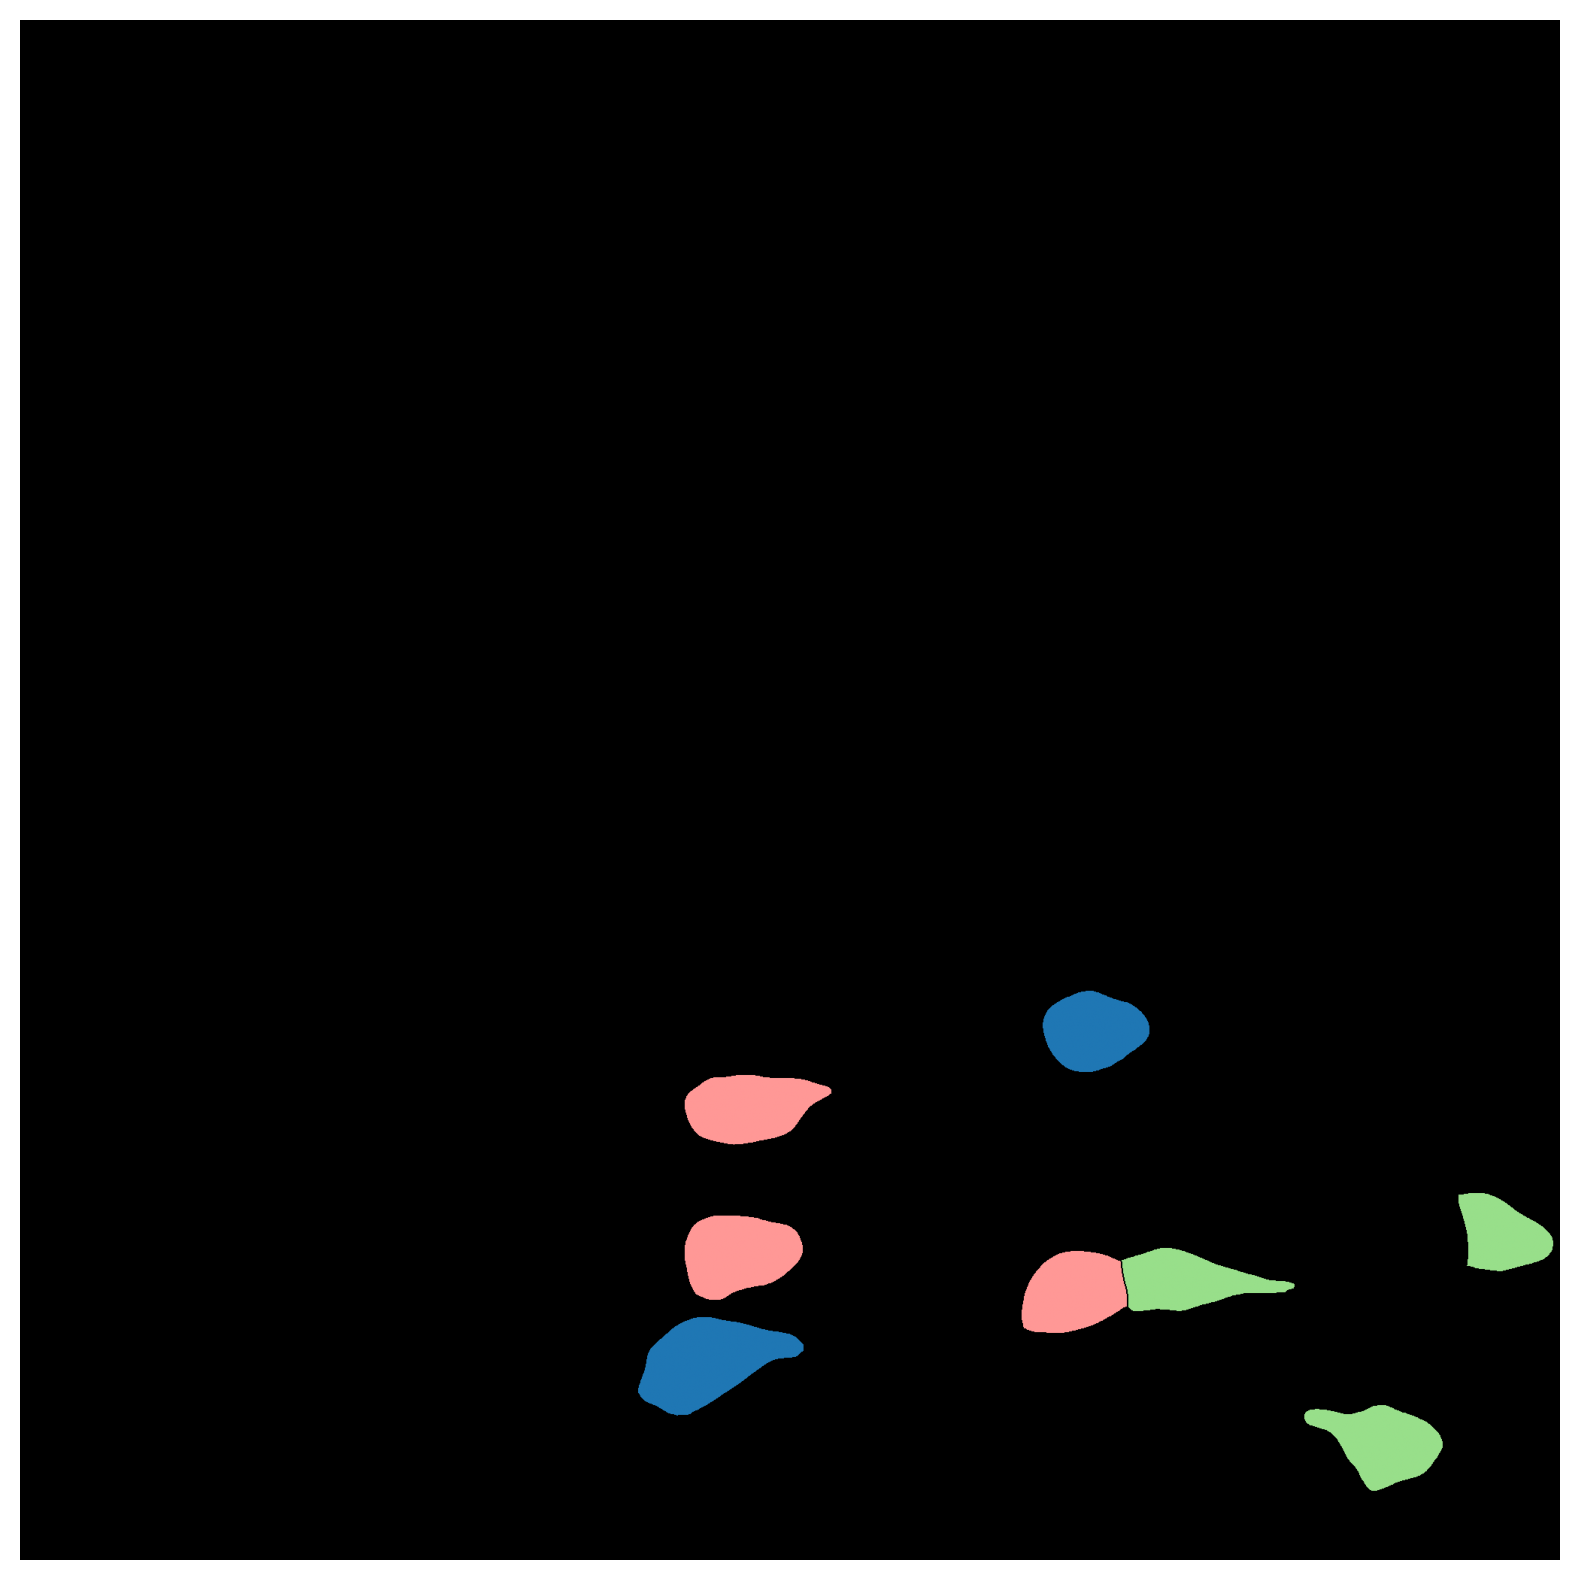

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a label for the background, if it exists, e.g., 0 for background
background_label = 0

# Extract unique cluster IDs from the mask, excluding the background label
unique_clusters = np.unique(mask_copy)
unique_clusters = unique_clusters[unique_clusters != background_label]  # Remove background label from clusters

# Initialize the mask_colored with a black background
mask_colored = np.zeros((*mask_copy.shape, 3), dtype=float)  # Create an RGB array filled with zeros (black background)

# Apply the color map to the mask
for cluster_id in unique_clusters:
    if cluster_id in celltype_def:
        celltype = celltype_def[int(cluster_id)]
        mask_colored[mask_copy == cluster_id] = category_colors[celltype]
    else:
        # Assign black color to clusters not in celltype_def
        mask_colored[mask_copy == cluster_id] = [0, 0, 0]

# Display the mask with the black background and colored clusters
plt.figure(figsize=(10, 10))
plt.imshow(mask_colored)
plt.axis('off')  # Hide the axes
#plt.savefig("projected_labels_on_masks.svg", bbox_inches='tight', pad_inches=0)
plt.show()

In [60]:
## Do for all
from pathlib import Path
output_dir  = Path("/groups/CaiLab/personal/Lex/raw/250113_mb_BSpeg_xtra_potentialTriton/pyfish_tools/output/spatial_mapped_masks")
output_dir.mkdir(parents=True, exist_ok=True)


for pos in range(87):
    try:
        mask_path = f"/groups/CaiLab/personal/Lex/raw/250113_mb_BSpeg_xtra_potentialTriton/pyfish_tools/output/edges_deleted/MMStack_Pos{pos}_z0.tif"
        #read mask
        mask = tf.imread(mask_path)
        # Extract Pos information from filename (assuming consistent naming)
        pos = int(mask_path.split("Pos")[1].split("_")[0]) 
        
        #make copy
        mask_copy = mask.copy().astype(np.int16)
        #grab leiden labels
        labels = pd.DataFrame(adata.obs["cell_type"])
    
        # Parse cell_id and Pos from the index
        labels.reset_index(inplace=True)
        labels[['cell_id', 'pos']] = labels['index'].str.extract(r'Cell(\d+)\.0_Pos_(\d+)', expand=True).astype(int)
        labels = labels[['cell_id', 'pos', 'cell_type']]
        
        # Filter labels for the current Pos
        labels = labels[labels['pos'] == pos]
       
        #make cell type dictionary
        celltype_def = dict(zip(labels['cell_id'], labels['cell_type']))
    
        # Define a label for the background, if it exists, e.g., 0 for background
        background_label = 0
        
        # Extract unique cluster IDs from the mask, excluding the background label
        unique_clusters = np.unique(mask_copy)
        unique_clusters = unique_clusters[unique_clusters != background_label]  # Remove background label from clusters
        
        # Initialize the mask_colored with a black background
        mask_colored = np.zeros((*mask_copy.shape, 3), dtype=float)  # Create an RGB array filled with zeros (black background)
        
        # Apply the color map to the mask
        for cluster_id in unique_clusters:
            if cluster_id in celltype_def:
                celltype = celltype_def[int(cluster_id)]
                mask_colored[mask_copy == cluster_id] = category_colors[celltype]
            else:
                # Assign black color to clusters not in celltype_def
                mask_colored[mask_copy == cluster_id] = [0, 0, 0]
        
        # Display the mask with the black background and colored clusters
        tf.imwrite(str(output_dir / f"MMStack_Pos{pos}.ome.tif"), mask_colored)
    except:
        continue